In [2]:
from spacy import displacy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import os
from functools import partial

import data
import plot

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from chatty.utils import tokens

train, train_vecs, test, test_vecs = data.get_data(use_cached=True)
# train[['utter_t-3', 'utter_t-2', 'utter_t-1']] = data.get_lags(train[['utter']], lag_range=[3, 2, 1])
del train_vecs, test_vecs

/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Using Cached


In [4]:
%reload_ext chatty.utils.tokens
from chatty.utils import tokens

tokens.list_vocabs()

(['chunk_pos_bigram', 'pos_ngram_2', 'word'],
 ['dependencies', 'lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['word'],
 ['lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'subjects_dependency_pos'],
 ['subjects_dependency_pos', 'word_ngram_2'])

In [5]:
vocab = tokens.load_vocab('chunk_pos_bigram', 'pos_ngram_2', 'word')['vocab']
vocab = [tokens.token_joiner(i) for i in vocab]
vocab = np.array(vocab)

# Random Forest

In [4]:
ACT_MASK = train['act'].notnull()
# X = train[ACT_MASK].values
X = vocab[ACT_MASK]
y = train['act'][ACT_MASK].values

clf = Pipeline([
    ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('random', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1, verbose=True))
])

In [5]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


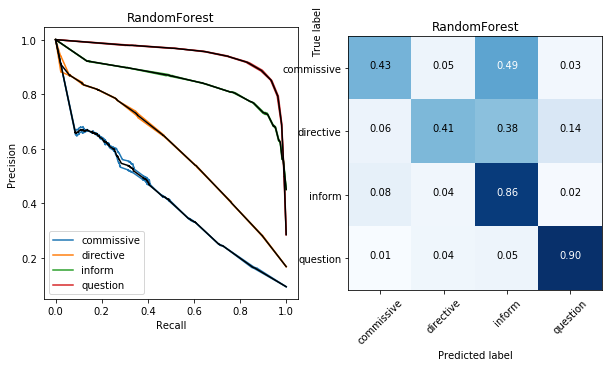

In [6]:
plot.plot_prec_rec(results, 'RandomForest', normalize_confusion_matrix=True)

In [7]:
names = results['models'][0].named_steps['countvectorizer'].get_feature_names()

importances = results['models'][0].named_steps['RandomForest'].feature_importances_
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, importances), key=lambda x: x[1], reverse=True))))

[(0, ('LEMMA_?', 0.06343056925105947)),
 (1, ('LEMMA_.', 0.036309727242177535)),
 (2, ('LEMMA_do_LEMMA_-PRON-', 0.009997777455942)),
 (3, ('LEMMA_what', 0.009876773488733618)),
 (4, ('CHK_ROOT_POS_NOUN_CHK_ROOT_HEAD_VERB', 0.007274214849813982)),
 (5, ('LEMMA_ ', 0.007191519453667872)),
 (6, ('LEMMA_-PRON-', 0.006103797783272885)),
 (7, ('LEMMA_-PRON-_LEMMA_?', 0.006012218521531308)),
 (8, ('CHK_ROOT_POS_PRON_CHK_ROOT_HEAD_VERB', 0.005924702893739832)),
 (9, ('LEMMA_do', 0.005322658387943862)),
 (10, ('LEMMA_be_LEMMA_-PRON-', 0.004813546808739252)),
 (11, ('LEMMA_be', 0.0047378933470829925)),
 (12, ('LEMMA_how', 0.0045971997013752545)),
 (13, ('LEMMA_ _LEMMA_-PRON-', 0.004556051988394024)),
 (14, ('CHK_ROOT_POS_NOUN_CHK_ROOT_HEAD_ADP', 0.004170748952106978)),
 (15, ('LEMMA_,', 0.003967950429351206)),
 (16, ('LEMMA_will', 0.003797589708251221)),
 (17, ('LEMMA_please', 0.003718060720797838)),
 (18, ('LEMMA_to', 0.00354411367232738)),
 (19, ('LEMMA_ok', 0.00347244782752665)),
 (20, ('LEMM

(0, 0.05)

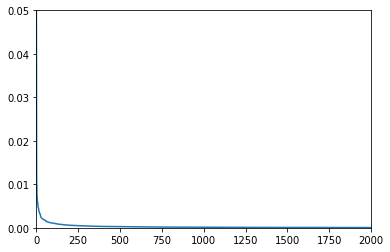

In [8]:
plt.plot(sorted(importances, reverse=True))
plt.xlim(0, 2000)
plt.ylim(0, .05)

In [ ]:
# train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
# train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])


# ACT_MASK = train['emo'].notnull() \
#          & train['vocab_t-1'].notnull() \
#          & train['vocab_t-2'].notnull() \
#          & train['vocab_t-3'].notnull()

# assert train['emo'][train['emo'].notnull()].shape[0] \
#       == train_vecs[train['emo'].notnull()].shape[0]


# X = train[LAG_MASK][ACT_MASK].values

# Try with SVM

In [4]:
from sklearn.linear_model import SGDClassifier

In [7]:
ACT_MASK = train['act'].notnull()
# X = train[ACT_MASK].values
X = vocab[ACT_MASK]
y = train['act'][ACT_MASK].values

clf = Pipeline([
    ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('random', RandomOverSampler('minority')),
    ('SupportVectorClassifier', SGDClassifier(n_jobs=-1, loss='log'))
])

In [8]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


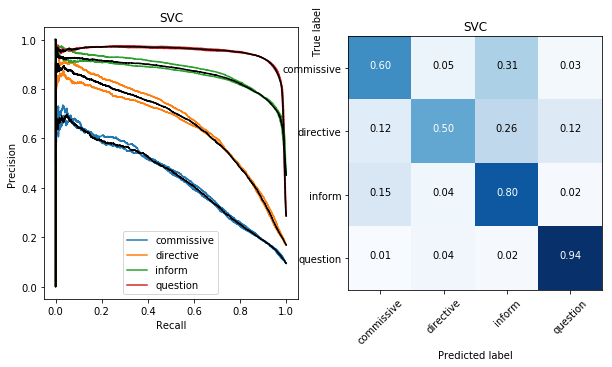

In [9]:
plot.plot_prec_rec(results, 'SVC', normalize_confusion_matrix=True)

In [24]:
a = results['models'][0]
b = a.named_steps['SupportVectorClassifier']
b.coef_

array([[ 0.3552573 , -0.41392853, -0.44865605, ..., -0.25761623,
        -0.00235247, -0.00146027],
       [-0.279334  , -0.16663419,  0.06484304, ..., -0.10018078,
        -0.03101458, -0.01389   ],
       [-0.18166971,  0.17739271,  0.32677867, ...,  0.23218016,
         0.01724759,  0.01650041],
       [ 0.10411931,  0.07925959, -0.04061363, ...,  0.20097845,
        -0.00339122, -0.00267095]])

In [25]:
b.classes_

array(['commissive', 'directive', 'inform', 'question'], dtype='<U10')

In [26]:
b.coef_[0]

array([ 0.3552573 , -0.41392853, -0.44865605, ..., -0.25761623,
       -0.00235247, -0.00146027])

In [27]:
names = results['models'][0].named_steps['countvectorizer'].get_feature_names()
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, b.coef_[0]), key=lambda x: x[1], reverse=True))))

[(0, ('LEMMA_ ', 2.5020682583892433)),
 (1, ('LEMMA_good_LEMMA_idea', 1.9079709217936631)),
 (2, ('LEMMA_?_LEMMA_no', 1.7015384938405218)),
 (3, ('LEMMA_?_LEMMA_let', 1.684752838511015)),
 (4, ('LEMMA_to_LEMMA_.', 1.5958234870925898)),
 (5, ('LEMMA_ _LEMMA_sure', 1.5555778100660704)),
 (6, ('LEMMA_?_LEMMA_that', 1.4808374732258467)),
 (7, ('LEMMA_?_LEMMA_-PRON-', 1.4695917115901231)),
 (8, ('LEMMA_ _LEMMA_here', 1.387507402593364)),
 (9, ('LEMMA_ _LEMMA_all', 1.3788758008861077)),
 (10, ('LEMMA_ _LEMMA_certainly', 1.3627822229683688)),
 (11, ('LEMMA_will_LEMMA_.', 1.3574207398386882)),
 (12, ('LEMMA_feel_LEMMA_like', 1.353611717036978)),
 (13, ('LEMMA_here_LEMMA_-PRON-', 1.3459090869210517)),
 (14, ('LEMMA_for_LEMMA_.', 1.2928887006724585)),
 (15, ('LEMMA_no_LEMMA_problem', 1.2172284529699766)),
 (16, ('LEMMA_could_LEMMA_.', 1.2119547637463266)),
 (17, ('LEMMA_no_LEMMA_way', 1.151314807463232)),
 (18, ('LEMMA_not_LEMMA_like', 1.1457526406452405)),
 (19, ('LEMMA_ _LEMMA_of', 1.140285569

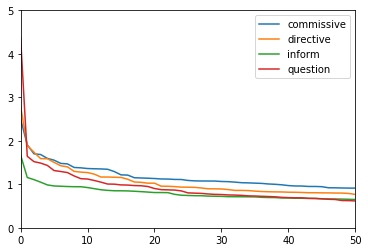

In [41]:
for i in range(4):
    plt.plot(sorted(b.coef_[i], reverse=True), label=b.classes_[i])
#     print(b.classes_[i])
    plt.xlim(0, 50)
    plt.ylim(0, 5)
plt.legend()

# Try with Logreg

In [4]:
from sklearn.linear_model import LogisticRegression

In [42]:
ACT_MASK = train['act'].notnull()
# X = train[ACT_MASK].values
X = vocab[ACT_MASK]
y = train['act'][ACT_MASK].values

clf = Pipeline([
    ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('random', RandomOverSampler('minority')),
    ('LogisticRegression', LogisticRegression(n_jobs=-1))
])

In [43]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1235: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1235: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


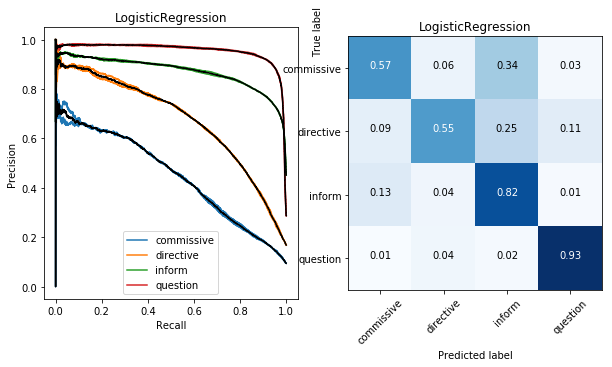

In [44]:
plot.plot_prec_rec(results, 'LogisticRegression', normalize_confusion_matrix=True)

In [45]:
a = results['models'][0]
b = a.named_steps['LogisticRegression']
b.coef_

array([[ 0.25302574, -0.15766351,  0.45177335, ..., -0.17097424,
        -0.17097424, -0.9203887 ],
       [ 0.18095999, -0.09623262,  0.0185052 , ..., -0.00130284,
        -0.00130284,  0.52784438],
       [-0.31700268,  0.01391557,  0.37010918, ...,  0.11136787,
         0.11136787,  0.44518965],
       [-0.13558265,  0.17336421, -1.14744445, ..., -0.00269571,
        -0.00269571,  0.5382286 ]])

In [25]:
b.classes_

array(['commissive', 'directive', 'inform', 'question'], dtype='<U10')

In [26]:
b.coef_[0]

array([ 0.3552573 , -0.41392853, -0.44865605, ..., -0.25761623,
       -0.00235247, -0.00146027])

In [46]:
names = results['models'][0].named_steps['countvectorizer'].get_feature_names()
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, b.coef_[0]), key=lambda x: x[1], reverse=True))))

[(0, ('LEMMA_ ', 3.8359832151122784)),
 (1, ('LEMMA_?_LEMMA_no', 3.4953594152977856)),
 (2, ('LEMMA_ _LEMMA_here', 2.7545025217642003)),
 (3, ('LEMMA_could_LEMMA_.', 2.5517105055093867)),
 (4, ('LEMMA_should_LEMMA_.', 2.4811925636447847)),
 (5, ('LEMMA_ _LEMMA_all', 2.472699846160978)),
 (6, ('LEMMA_?_LEMMA_let', 2.4159705267413085)),
 (7, ('LEMMA_ _LEMMA_sure', 2.3865025476847848)),
 (8, ('LEMMA_that_LEMMA_enough', 2.3118822825481065)),
 (9, ('LEMMA_?_LEMMA_-PRON-', 2.2426464284962377)),
 (10, ('LEMMA_could_LEMMA_,', 2.20156052412393)),
 (11, ('LEMMA_?_LEMMA_that', 2.1854853495431907)),
 (12, ('LEMMA_the_LEMMA_fish', 2.1468292448708275)),
 (13, ('LEMMA_afraid_LEMMA_this', 2.1289405090026023)),
 (14, ('LEMMA_to_LEMMA_,', 2.1213943713091115)),
 (15, ('LEMMA_just_LEMMA_can', 2.091235972347794)),
 (16, ('LEMMA_please_LEMMA_do', 2.0852271695586833)),
 (17, ('LEMMA_a_LEMMA_deal', 2.0710744281717166)),
 (18, ('LEMMA_nothing_LEMMA_do', 2.052810681917178)),
 (19, ('LEMMA_-PRON-_LEMMA_way', 2.0

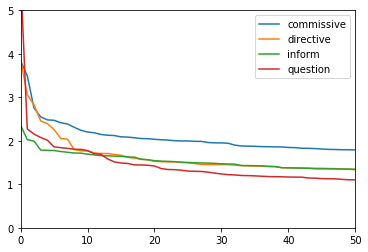

In [47]:
for i in range(4):
    plt.plot(sorted(b.coef_[i], reverse=True), label=b.classes_[i])
#     print(b.classes_[i])
    plt.xlim(0, 50)
    plt.ylim(0, 5)
plt.legend()

# Try an AdaBoost

In [50]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [52]:
ACT_MASK = train['act'].notnull()
# X = train[ACT_MASK].values
X = vocab[ACT_MASK]
y = train['act'][ACT_MASK].values

clf = Pipeline([
    ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('random', RandomOverSampler('minority')),
    ('AdaBoost', AdaBoostClassifier())
])

In [53]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training
Training


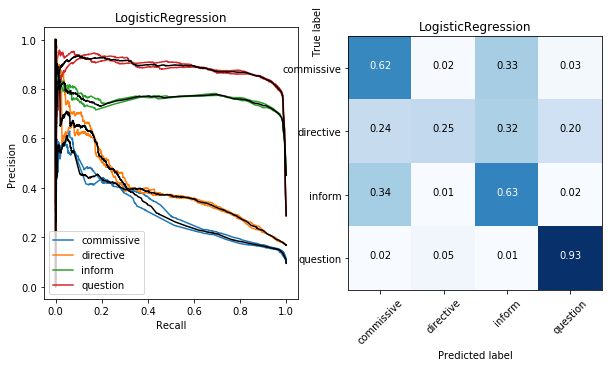

In [54]:
plot.plot_prec_rec(results, 'LogisticRegression', normalize_confusion_matrix=True)

In [57]:
names = results['models'][0].named_steps['countvectorizer'].get_feature_names()

importances = results['models'][0].named_steps['AdaBoost'].feature_importances_
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, importances), key=lambda x: x[1], reverse=True))))

[(0, ('CHK_ROOT_POS_NOUN_CHK_ROOT_HEAD_VERB', 0.02)),
 (1, ('LEMMA_ ', 0.02)),
 (2, ('LEMMA_ _LEMMA_be', 0.02)),
 (3, ('LEMMA_ _LEMMA_sure', 0.02)),
 (4, ('LEMMA_,_LEMMA_be', 0.02)),
 (5, ('LEMMA_-PRON-', 0.02)),
 (6, ('LEMMA_-PRON-_LEMMA_do', 0.02)),
 (7, ('LEMMA_-PRON-_LEMMA_parent', 0.02)),
 (8, ('LEMMA_-PRON-_LEMMA_should', 0.02)),
 (9, ('LEMMA_-PRON-_LEMMA_will', 0.02)),
 (10, ('LEMMA_.', 0.02)),
 (11, ('LEMMA_._LEMMA_be', 0.02)),
 (12, ('LEMMA_?', 0.02)),
 (13, ('LEMMA_?_LEMMA_-PRON-', 0.02)),
 (14, ('LEMMA_?_LEMMA_no', 0.02)),
 (15, ('LEMMA_animal', 0.02)),
 (16, ('LEMMA_ask_LEMMA_if', 0.02)),
 (17, ('LEMMA_be', 0.02)),
 (18, ('LEMMA_bob', 0.02)),
 (19, ('LEMMA_can', 0.02)),
 (20, ('LEMMA_can_LEMMA_-PRON-', 0.02)),
 (21, ('LEMMA_canada', 0.02)),
 (22, ('LEMMA_could_LEMMA_-PRON-', 0.02)),
 (23, ('LEMMA_do_LEMMA_-PRON-', 0.02)),
 (24, ('LEMMA_good_LEMMA_idea', 0.02)),
 (25, ('LEMMA_how', 0.02)),
 (26, ('LEMMA_how_LEMMA_about', 0.02)),
 (27, ('LEMMA_impossible_LEMMA_.', 0.02)),
 (2

(0, 0.05)

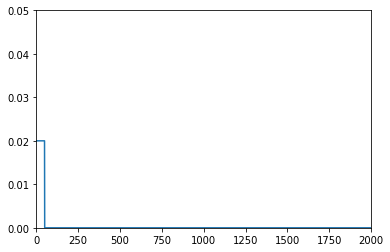

In [58]:
plt.plot(sorted(importances, reverse=True))
plt.xlim(0, 2000)
plt.ylim(0, .05)

# Try Ensemble

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV # <<<<< use to finalize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [77]:
log_reg_pca = Pipeline([
    ('pca', TruncatedSVD(n_components=30)),
    ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg'))
])

vt = VotingClassifier([
    ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg')),
    ('svc', SGDClassifier(loss='log', n_jobs=-1)),
    ('adaboost', AdaBoostClassifier())
], n_jobs=1, voting='soft')

ACT_MASK = train['act'].notnull()
# X = train[ACT_MASK].values
X = vocab[ACT_MASK]
y = train['act'][ACT_MASK].values

clf = Pipeline([
#     ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('tfidf_vec', TfidfVectorizer(analyzer=tokens.token_splitter, use_idf=False)),
    ('random', RandomOverSampler('minority')),
    ('votingclassifier', vt)
])

In [78]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


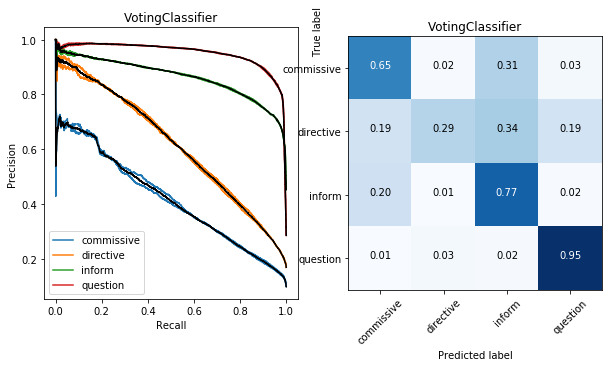

In [82]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

In [97]:
results['classes']

array(['commissive', 'directive', 'inform', 'question'], dtype=object)

In [108]:
train['act_pred'] = 'stuff' # initialize the full length of the dataframe
train['act_pred'][ACT_MASK] = np.array([results['classes'][i] 
                                        for i in np.concatenate(results['y_proba'], axis=0)\
                                        .argmax(axis=1)])

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Try with utterances t-1 & t-2

In [4]:
from sklearn.pipeline import FeatureUnion
from chatty.utils.vectorize import CountVectorizerColumnN

In [7]:
train['vocab'] = vocab

In [9]:
# LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']
# train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])
LAG_MASK = ['vocab_t-2', 'vocab_t-1']
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[2, 1])
ACT_MASK = train['act'].notnull() \
         & train['vocab'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull()

In [12]:
# log_reg_pca = Pipeline([
#     ('pca', TruncatedSVD(n_components=30)),
#     ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg'))
# ])

# svc = CalibratedClassifierCV(SGDClassifier(loss='log', n_jobs=-1))
# adaboost = CalibratedClassifierCV(AdaBoostClassifier())
svc = SGDClassifier(loss='log', n_jobs=-1)
adaboost = AdaBoostClassifier()

vt = VotingClassifier([
    ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg')),
    ('svc', svc),
    ('adaboost', adaboost)
], n_jobs=1, voting='soft')


fu = FeatureUnion([('vocab_t-2', CountVectorizerColumnN(analyzer=tokens.token_splitter, colnum=0, normalize=True)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=tokens.token_splitter, colnum=1, normalize=True)),
                   ('vocab', CountVectorizerColumnN(analyzer=tokens.token_splitter, colnum=2))])

X = train[['vocab_t-2', 'vocab_t-1', 'vocab']][ACT_MASK].values
y = train['act'][ACT_MASK].values

clf = Pipeline([
#     ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('feature_union_countvecs', fu),
#     ('tfidf_vec', TfidfVectorizer(analyzer=tokens.token_splitter, use_idf=False)),
    ('random', RandomOverSampler('minority')),
    ('votingclassifier', vt)
])

In [13]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


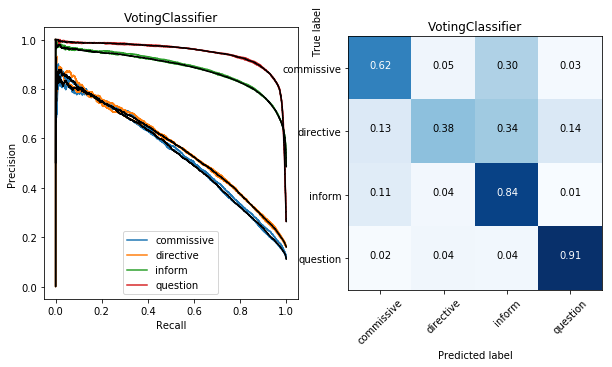

In [14]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

# Try with utterances t-1 & t-2 include POS bigrams of the document

In [19]:
from sklearn.pipeline import FeatureUnion
from chatty.utils.vectorize import CountVectorizerColumnN
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

In [6]:
tokens.list_vocabs()

(['dependencies', 'lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'subjects_dependency_pos'],
 ['chunk_pos_bigram', 'pos_ngram_2', 'word'],
 ['subjects_dependency_pos', 'word_ngram_2'],
 ['word'],
 ['chunk_pos_bigram', 'lemma_ngram_2', 'pos_ngram_2', 'word'])

In [7]:
vocab = tokens.load_vocab('chunk_pos_bigram', 'lemma_ngram_2', 'pos_ngram_2', 'word')['vocab']
vocab = [tokens.token_joiner(i) for i in vocab]
vocab = np.array(vocab)

In [8]:
train['vocab'] = vocab

In [9]:
# LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']
# train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])
LAG_MASK = ['vocab_t-1']
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[1])
ACT_MASK = train['act'].notnull() \
         & train['vocab'].notnull() \
         & train['vocab_t-1'].notnull() \
#          & train['vocab_t-2'].notnull()

In [20]:
# log_reg_pca = Pipeline([
#     ('pca', TruncatedSVD(n_components=30)),
#     ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg'))
# ])

svc = CalibratedClassifierCV(SGDClassifier(loss='log', n_jobs=-1))
# adaboost = CalibratedClassifierCV(AdaBoostClassifier())
# svc = SGDClassifier(loss='log', n_jobs=-1)
bnb = CalibratedClassifierCV(BernoulliNB())
adaboost = AdaBoostClassifier()

vt = VotingClassifier([
    ('logreg', LogisticRegression(n_jobs=-1, solver='newton-cg')),
    ('svc', svc),
    ('bnb', bnb),
    ('adaboost', adaboost)
], n_jobs=1, voting='soft', weights=[
    1, 1, 1, 1
])


fu = FeatureUnion([('vocab_t-1', CountVectorizerColumnN(analyzer=tokens.token_splitter, colnum=0, normalize=True)),
                   ('vocab', CountVectorizerColumnN(analyzer=tokens.token_splitter, colnum=1, normalize=True))])

X = train[['vocab_t-1', 'vocab']][ACT_MASK].values
y = train['act'][ACT_MASK].values

clf = Pipeline([
#     ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('feature_union_countvecs', fu),
#     ('tfidf_vec', TfidfVectorizer(analyzer=tokens.token_splitter, use_idf=False)),
    ('random', RandomOverSampler('minority')),
    ('votingclassifier', vt)
])

##### Try with calibrated SVM classifier

In [21]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), Futur

Training


/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), Futur

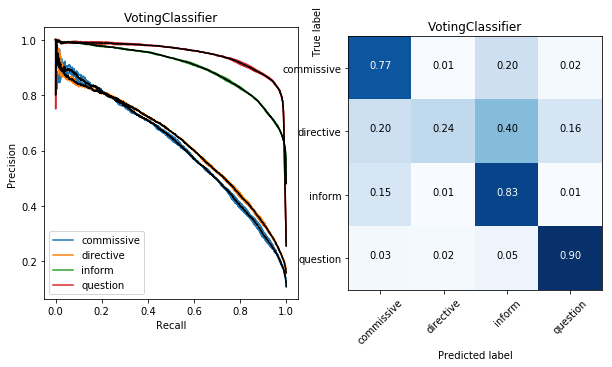

In [22]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

In [24]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


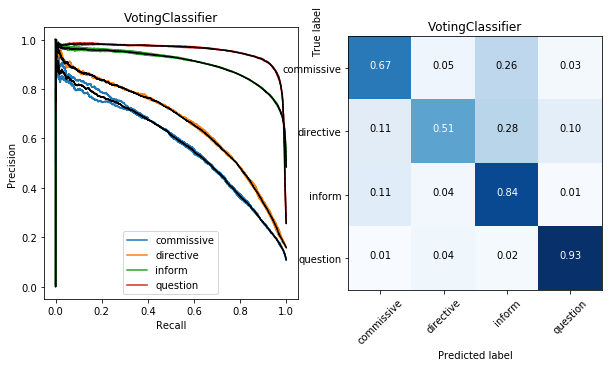

In [25]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)